# Offline Path Planning Optimization by Segmented Bezier Curves

This notebook demonstrates a practical example of path planning using Bezier curves in each segment. In both explored approaches, a single Bezier curve is fit within each segment. The control points are then determined to obtain a path of minimum curvature, curvature variation with curvature continuity.

![](figures/cubic_segment.png)

In [57]:
import time
import nlopt
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize
import scipy.special
from cubic_bezier_planner import calc_bezier_path
from cubic_spline_planner import calc_spline_course

In [58]:
class Path:
    def __init__(self, x, y, yaw, k):
        self.x = x
        self.y = y
        self.yaw = yaw
        self.k = k

## Calculating Bezier Curve Control Points

### Cubic Bezier Path
A cubic Bezier path requires 4 control points, solved by being input the start and end conditions in position and yaw. The offset expresses the distance from each endpoint to middle control points as a fraction of the segment length.

### Quintic Bezier Path
A quintic Bezier path requires 6 control points. It has the key advantage that the curvature or likewise the second derivative may be manipulated at the start and endpoints to obtain a curvature continuous path. Once again, the offset expresses the distance from each endpoint to middle control points as a fraction of the segment length. The method implemented to derive the 6 control points from a position, heading and second derivative vector at the start and endpoints are described in this paper:
http://www2.informatik.uni-freiburg.de/~lau/students/Sprunk2008.pdf

In [59]:
"""
Compute control points and path given start and end conditions in yaw and position for a cubic bezier spline
"""
def calc_4points_bezier_path(sx, sy, syaw, ex, ey, eyaw, offset):

    dist = np.hypot(sx - ex, sy - ey) * offset
    control_points = np.array(
        [[sx, sy],
         [sx + dist * np.cos(syaw), sy + dist * np.sin(syaw)],
         [ex - dist * np.cos(eyaw), ey - dist * np.sin(eyaw)],
         [ex, ey]])

    path = calc_bezier_path(control_points, n_points=170)
    return path, control_points


"""
Creating quintic bezier path controlling position, yaw, second derivative at start and end points
method proposed by /http://www2.informatik.uni-freiburg.de/~lau/students/Sprunk2008.pdf
"""
def calc_5ord_bezier_path(sx, sy, syaw, sdd, ex, ey, eyaw, edd, offset):

    dist_1 = np.hypot(sx - ex, sy - ey) * 0.9

    #create vectors of first and second derivatives
    sd = [dist_1 * np.cos(syaw), dist_1 * np.sin(syaw)]
    sd = np.multiply(sd, 0.2)
    sdd = np.multiply(sdd, dist_1)
    sdd = np.multiply(sdd, 150)
    ed = [dist_1 * np.cos(eyaw), dist_1 * np.sin(eyaw)]
    ed = np.multiply(ed, 0.2)
    edd = np.multiply(edd, dist_1)
    edd = np.multiply(edd, 150)

    # control points
    p0 = [sx, sy]
    p1 = np.add(p0, sd)
    p2 = np.subtract(2*p1, p0)
    p2 = np.add(p2, sdd)
    p5 = [ex, ey]
    p4 = np.subtract(p5, ed)
    p3 = np.subtract(2*p4, p5)
    p3 = np.add(p3, edd)    

    control_points = np.array((p0, p1, p2, p3, p4, p5))
    path = calc_bezier_path(control_points, n_points=170)

    return path, control_points

# Spline Class
A spline class is initated with an input set of waypoints and a maximum deviation. Boundary lines are constructed, and this class features functions for calculating derivatives, yaw, curvature and path distance.

In [60]:
class Spline():

    def __init__(self, ax, ay, bound):
        
        #input waypoint coordinates
        ayaw, k = self.calc_yaw_curvature(ax, ay)
        self.waypoints = Path(ax, ay, ayaw, k)
        
        # defines and sets left and right boundary lines
        self.bound = bound
        lax, lay, rax, ray = self.init_boundary()
        self.left_bound = Path(lax, lay, None, None)
        self.right_bound = Path(rax, ray, None, None)

        # default unoptimized cubic bezier path to initialize curvature
        bx, by, _, _ = self.cubic_bezier_path(ax, ay)
        byaw, bk = self.calc_yaw_curvature(bx, by)
        self.default_path = Path(bx, by, byaw, bk)

        # default seeding path for cubic spline
        cx, cy, cyaw, ck, _ = calc_spline_course(ax, ay, 0.5)
        self.seeding_path = Path(cx, cy, cyaw, ck)

        self.optimized_path = Path([], [], [], [])
        self.ctr_points = Path([], [], [], [])

    # Calculates the first derivative of input arrays
    def calc_d(self, x, y):

        dx, dy = [], []

        for i in range(0, len(x)-1):
            dx.append(x[i+1] - x[i])
            dy.append(y[i+1] - y[i])
        
        dx.append(dx[-1])
        dy.append(dy[-1])
        return dx, dy

    # Calculates yaw and curvature given input path
    def calc_yaw_curvature(self, x, y):

        dx, dy = self.calc_d(x,y)
        ddx, ddy = self.calc_d(dx, dy)
        yaw = []
        k = []

        for i in range(0, len(x)):
            yaw.append(math.atan2(dy[i], dx[i]))
            k.append( (ddy[i] * dx[i] - ddx[i] * dy[i]) / ((dx[i]**2 + dy[i]**2)**(3/2)) )
    
        return yaw, k

    # Calculates total distance of the path
    def calc_path_dist(self, x, y):

        dx = np.absolute(self.calc_d(np.zeros(len(x)), x))
        dy = np.absolute(self.calc_d(np.zeros(len(y)), y))
        ddist = np.hypot(dx, dy)

        return np.sum(ddist)


    # Determines position of boundary lines for visualization
    def init_boundary(self):

        rax, ray, lax, lay = [], [], [], []

        for n in range(0, len(self.waypoints.yaw)):
            lax.append(self.waypoints.x[n] - self.bound*np.sin(self.waypoints.yaw[n]))
            lay.append(self.waypoints.y[n] + self.bound*np.cos(self.waypoints.yaw[n]))
            rax.append(self.waypoints.x[n] + self.bound*np.sin(self.waypoints.yaw[n]))
            ray.append(self.waypoints.y[n] - self.bound*np.cos(self.waypoints.yaw[n]))
        
        return lax, lay, rax, ray



## Piecewise Bezier Curve Interpolation Through Waypoints

### Determining Heading Conditions
Both approaches require the heading conditions at each waypoint, which is determined as the normal to the bisector of the angle formed from the 2 adjacent waypoints.
https://users.soe.ucsc.edu/~elkaim/Documents/camera_WCECS2008_IEEE_ICIAR_58.pdf

### Determining Curvature Conditions for Quintic Spline
In order to determine the second derivative conditions for a quintic spline, a cubic Bezier spline must first be plotted through the waypoints. This expectdly results in curvature discontinuity at each instance of joining cubic Bezier curves. The 2nd derivative condition at this waypoint is then determined as a weighted average of the start and end points, with a resultant curvature profile seen in the black line.
http://www2.informatik.uni-freiburg.de/~lau/students/Sprunk2008.pdf

![](figures/heuristic.png)

In [61]:
class Spline(Spline):

    # Bezier path one as per the approach suggested in
    # https://users.soe.ucsc.edu/~elkaim/Documents/camera_WCECS2008_IEEE_ICIAR_58.pdf
    def cubic_bezier_path(self, ax, ay):

        dyaw, _ = self.calc_yaw_curvature(ax, ay)
        
        # control point and path array
        cx, cy, ctr_pt_x, ctr_pt_y = [], [], [], []

        ayaw = dyaw.copy()

        for n in range(1, len(ax)-1):
            yaw = 0.5*(dyaw[n] + dyaw[n-1])
            ayaw[n] = yaw

        # for n waypoints, there are n-1 bezier curves
        for i in range(len(ax)-1):

            path, points = calc_4points_bezier_path(ax[i], ay[i], ayaw[i], ax[i+1], ay[i+1], ayaw[i+1], 0.4)
            cx = np.concatenate((cx, path.T[0][:-1]))
            cy = np.concatenate((cy, path.T[1][:-1]))
            cyaw, k = self.calc_yaw_curvature(cx, cy)

            for p in points:
                ctr_pt_x.append( p[0] )
                ctr_pt_y.append( p[1] )

        return cx, cy, ctr_pt_x, ctr_pt_y

    # Approximated quintic bezier path with curvature continuity
    def quintic_bezier_path(self, ax, ay, offset):

        dyaw, _ = self.calc_yaw_curvature(ax, ay)
        
        # control point and path array
        cx, cy, ctr_pt_x, ctr_pt_y = [], [], [], []

        # heading conditions by normal to bisector of each vertex
        ayaw = dyaw.copy()
        for n in range(1, len(ax)-1):
            yaw = 0.5*(dyaw[n] + dyaw[n-1])
            ayaw[n] = yaw

        # obtain target second derivative
        ddx, ddy = self.calc_2nd_derivative_heuristic(ax, ay)

        # for n waypoints, there are n-1 bezier curves
        for i in range(len(ax)-1):

            path, points = calc_5ord_bezier_path(ax[i], ay[i], ayaw[i], [ ddx[i], ddy[i] ], 
                                                        ax[i+1], ay[i+1], ayaw[i+1], [ ddx[i+1], ddy[i+1] ],
                                                        offset[i])

            cx = np.concatenate((cx, path.T[0][:-1]))
            cy = np.concatenate((cy, path.T[1][:-1]))
            cyaw, k = self.calc_yaw_curvature(cx, cy)
            
            for p in points:
                ctr_pt_x.append( p[0] )
                ctr_pt_y.append( p[1] )

        return cx, cy, ctr_pt_x, ctr_pt_y
    
            
    # Calculates the second derivative conditions for an input waypointbased on approach in
    # http://www2.informatik.uni-freiburg.de/~lau/students/Sprunk2008.pdf
    def calc_2nd_derivative_heuristic(self, ax, ay):

        # array of second derivative conditions, initialized with start condition of 0
        ddx, ddy = [0.0], [0.0]

        # target yaw
        dyaw, _ = self.calc_yaw_curvature(ax, ay)
        ayaw = dyaw.copy()  
        for n in range(1, len(ax)-1):
            yaw = 0.5*(dyaw[n] + dyaw[n-1])
            ayaw[n] = yaw

        # range of endpoints from which to calc average
        endpoint_range = 7

        # for n waypoints, n-2 waypoints, excluding start and end are assigned 2nd derivative conditions
        for i in range(len(ax)-2):

            # bezier path before
            path1, _ = calc_4points_bezier_path(ax[i], ay[i], ayaw[i], ax[i+1], ay[i+1], ayaw[i+1], 0.4)
            dx1, dy1 = self.calc_d(path1.T[0], path1.T[1])
            ddx1, ddy1 = self.calc_d(dx1, dy1)
            ddx1 = np.mean( ddx1[-endpoint_range:] )
            ddy1 = np.mean( ddy1[-endpoint_range:] )

            # bezier path after
            path2, _ = calc_4points_bezier_path(ax[i+1], ay[i+1], ayaw[i+1], ax[i+2], ay[i+2], ayaw[i+2], 0.4)
            dx2, dy2 = self.calc_d(path2.T[0], path2.T[1])
            ddx2, ddy2 = self.calc_d(dx2, dy2)
            ddx2 = np.mean( ddx2[:endpoint_range] )
            ddy2 = np.mean( ddy2[:endpoint_range] )

            ddx.append( (ddx1 + ddx2) * 0.5 )
            ddy.append( (ddy1 + ddy2) * 0.5 )
        
        # append end conditions
        ddx.append(0.0)
        ddy.append(0.0)

        return ddx, ddy

## Optimization Strategy

Both methods may be optimized with the same desired path properties, essentially minimizing curvature and variation of curvature and distance if required. The cubic Bezier curve has an additional cost penalizing the curvature discontinuity at the point of joining two subsequent Bezier curves.

In [62]:
class Spline(Spline):
    
    # Objective function of cost to be minimized
    def cubic_objective_func(self, deviation):

        ax = self.waypoints.x.copy()
        ay = self.waypoints.y.copy()

        for n in range(0, len(deviation)):
            ax[n+1] -= deviation[n]*np.sin(self.waypoints.yaw[n+1])
            ay[n+1] += deviation[n]*np.cos(self.waypoints.yaw[n+1])

        bx, by, _, _ = self.cubic_bezier_path(ax, ay)
        yaw, k = self.calc_yaw_curvature(bx, by)

        # cost of curvature continuity
        dk, _ = self.calc_d(k, k)
        absolute_dk = np.absolute(dk)
        continuity_cost = 10.0 * np.mean(absolute_dk)

        # curvature cost
        absolute_k = np.absolute(k)
        curvature_cost = 14.0 * np.mean(absolute_k)
        
        # cost of deviation from input waypoints
        absolute_dev = np.absolute(deviation)
        deviation_cost = 1.0 * np.mean(absolute_dev)

        distance_cost = 0.5 * self.calc_path_dist(bx, by)

        return curvature_cost + deviation_cost + distance_cost + continuity_cost

    # Objective function for quintic bezier
    def quintic_objective_func(self, params):

        ax = self.waypoints.x.copy()
        ay = self.waypoints.y.copy()

        # calculate offsets and input waypoints
        waypoints = len(self.waypoints.yaw)
        deviation_lat = params[ :(waypoints-2) ]
        offset = params[ (waypoints-2): ]

        for n in range(0, len(self.waypoints.yaw)-2):
            ax[n+1] -= deviation_lat[n]*np.sin(self.waypoints.yaw[n+1])
            ay[n+1] += deviation_lat[n]*np.cos(self.waypoints.yaw[n+1])

        bx, by, _, _ = self.quintic_bezier_path(ax, ay, offset)
        yaw, k = self.calc_yaw_curvature(bx, by)

        # cost of curvature continuity
        dk, _ = self.calc_d(k, k)
        absolute_dk = np.absolute(dk)
        continuity_cost = 205.0 * np.mean(absolute_dk)

        # cost of distance
        # distance_cost = 0.5 * self.calc_path_dist(bx, by)

        # curvature cost
        absolute_k = np.absolute(k)
        curvature_cost = 25.0 * np.mean(absolute_k)
        
        # cost of deviation from input waypoints
        absolute_dev = np.absolute(deviation_lat)
        # deviation_cost = 1.0 * np.mean(absolute_dev)

        return curvature_cost + continuity_cost

    # Minimize objective function using scipy optimize minimize
    def optimize_min_cubic(self):

        print("Attempting optimization minima")

        initial_guess = [0, 0, 0, 0, 0]
        bnds = ((-self.bound, self.bound), (-self.bound, self.bound), (-self.bound, self.bound), (-self.bound, self.bound), (-self.bound, self.bound))
        result = optimize.minimize(self.cubic_objective_func, initial_guess, bounds=bnds)

        ax = self.waypoints.x.copy()
        ay = self.waypoints.y.copy()

        if result.success:
            print("optimized true")
            deviation = result.x
            for n in range(0, len(deviation)):
                ax[n+1] -= deviation[n]*np.sin(self.waypoints.yaw[n+1])
                ay[n+1] += deviation[n]*np.cos(self.waypoints.yaw[n+1])

            x, y, _, _ = self.cubic_bezier_path(ax, ay)
            yaw, k = self.calc_yaw_curvature(x, y)
            self.optimized_path = Path(x, y, yaw, k)

        else:
            print("optimization failure, defaulting")
            exit()

    # Minimize quintic objective function
    def optimize_min_quintic(self):

        print("Attempting optimization minima")

        initial_guess = [0, 0, 0, 0, 0, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7]

        bnds = ((-self.bound, self.bound), (-self.bound, self.bound), (-self.bound, self.bound), (-self.bound, self.bound), (-self.bound, self.bound), 
                (0, 1.0), (0, 1.0), (0, 1.0), (0, 1.0), (0, 1.0), (0, 1.0))
        result = optimize.minimize(self.quintic_objective_func, initial_guess, bounds=bnds)

        ax = self.waypoints.x.copy()
        ay = self.waypoints.y.copy()

        if result.success:
            print("optimized true")
            params = result.x
            
            # collects offsets for individual bezier curves
            waypoints = len(self.waypoints.yaw)
            deviation_lat = params[ :(waypoints-2) ]
            offset = params[ (waypoints - 2): ]
      

            # updated set of waypoints
            for n in range(0, len(self.waypoints.yaw)-2):
                ax[n+1] -= deviation_lat[n]*np.sin(self.waypoints.yaw[n+1])
                ay[n+1] += deviation_lat[n]*np.cos(self.waypoints.yaw[n+1])

            x, y, ctr_pt_x, ctr_pt_y = self.quintic_bezier_path(ax, ay, offset)
            yaw, k = self.calc_yaw_curvature(x, y)

            # update path optimized path and control points
            self.optimized_path = Path(x, y, yaw, k)
            self.ctr_points = Path(ctr_pt_x, ctr_pt_y, [], [])        

        else:
            print("optimization failure, defaulting")
            exit()

    def optimize_min_spline(self):

        self.default_path = self.seeding_path

        # number of points
        N = len(self.seeding_path.yaw)
        print("Optimizing {} points".format(N))


        # construct initial guess
        initial_guess = np.zeros(N-2)

        # construct bound
        bound = []
        for _ in range(N-2):
            bound.append((-self.bound, self.bound))
        bnds = tuple(bound)

        result = optimize.minimize(self.spline_objective_func, initial_guess, bounds=bnds)
    
        cx = self.seeding_path.x.copy()
        cy = self.seeding_path.y.copy()
        
        
        if result.success:
            print("optimized true")
            offsets = result.x
            
            # updated set of waypoints
            for n in range(N-2):
                cx[n+1] -= offsets[n]*np.sin(self.seeding_path.yaw[n+1])
                cy[n+1] += offsets[n]*np.cos(self.seeding_path.yaw[n+1])

            cyaw, ck = self.calc_yaw_curvature(cx, cy)

            self.optimized_path = Path(cx, cy, cyaw, ck)    

        else:
            print("optimization failure, defaulting")
            exit()

    # Objective function for quintic bezier
    def spline_objective_func(self, offsets):

        cx = self.seeding_path.x.copy()
        cy = self.seeding_path.y.copy()

        for n in range(len(cx)-2):
            cx[n+1] -= offsets[n]*np.sin(self.seeding_path.yaw[n+1])
            cy[n+1] += offsets[n]*np.cos(self.seeding_path.yaw[n+1])
        
        yaw, k = self.calc_yaw_curvature(cx, cy)
        absolute_k = np.absolute(k)
        curvature_cost = np.mean(absolute_k)

        dk, _ = self.calc_d(offsets, offsets)
        absolute_dk = np.absolute(dk)
        continuity_cost = np.mean(absolute_dk)

        distance_cost = self.calc_path_dist(cx, cy)

        absolute_offset = np.absolute(offsets)
        offset_cost = np.mean(absolute_offset)

        return 0.5*distance_cost + 0.0001*curvature_cost + 0.1*continuity_cost



Optimizing 106 points
optimized true
Solved in:  8.222769277999994


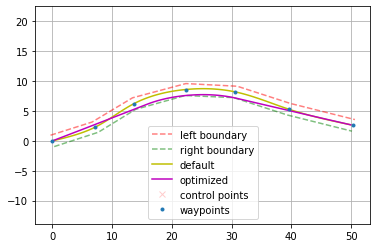

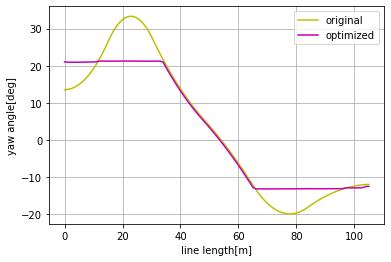

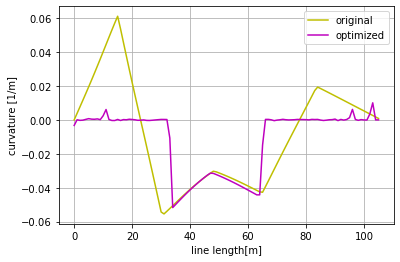

In [63]:
    # define input path
    ay = [0.0, 2.3, 6.25, 8.6, 8.2, 5.3, 2.6]
    ax = [0.0, 7.16, 13.68, 22.3, 30.64, 39.6, 50.4]
    boundary = 1.0

    spline = Spline(ax, ay, boundary)

    t0 = time.process_time()
    spline.optimize_min_spline()
    t1 = time.process_time() - t0
    print("Solved in: ", t1)

    # Path plot
    plt.subplots(1)
    plt.plot(spline.left_bound.x, spline.left_bound.y, '--r', alpha=0.5, label="left boundary")
    plt.plot(spline.right_bound.x, spline.right_bound.y, '--g', alpha=0.5, label="right boundary")
    plt.plot(spline.default_path.x, spline.default_path.y, '-y', label="default")
    plt.plot(spline.optimized_path.x, spline.optimized_path.y, '-m', label="optimized")
    plt.plot(spline.ctr_points.x, spline.ctr_points.y, 'xr', alpha=0.2, label="control points")
    plt.plot(spline.waypoints.x, spline.waypoints.y, '.', label="waypoints")
    plt.grid(True)
    plt.legend()
    plt.axis("equal")

    # Heading plot
    plt.subplots(1)
    plt.plot([np.rad2deg(iyaw) for iyaw in spline.default_path.yaw], "-y", label="original")
    plt.plot([np.rad2deg(iyaw) for iyaw in spline.optimized_path.yaw], "-m", label="optimized")
    plt.grid(True)
    plt.legend()
    plt.xlabel("line length[m]")
    plt.ylabel("yaw angle[deg]")

    # Curvature plot
    plt.subplots(1)
    plt.plot(spline.default_path.k, "-y", label="original")
    plt.plot(spline.optimized_path.k, "-m", label="optimized")
    plt.grid(True)
    plt.legend()
    plt.xlabel("line length[m]")
    plt.ylabel("curvature [1/m]")

    plt.show()

In [ ]:
    # define input path
    ay = [0.0, 2.3, 6.25, 8.6, 8.2, 5.3, 2.6]
    ax = [0.0, 7.16, 13.68, 22.3, 30.64, 39.6, 50.4]
    boundary = 1.0

    spline = Spline(ax, ay, boundary)

    t0 = time.process_time()
    spline.optimize_min_quintic()
    t1 = time.process_time() - t0
    print("Solved in: ", t1)

    # Path plot
    plt.subplots(1)
    plt.plot(spline.left_bound.x, spline.left_bound.y, '--r', alpha=0.5, label="left boundary")
    plt.plot(spline.right_bound.x, spline.right_bound.y, '--g', alpha=0.5, label="right boundary")
    plt.plot(spline.default_path.x, spline.default_path.y, '-y', label="default")
    plt.plot(spline.optimized_path.x, spline.optimized_path.y, '-m', label="optimized")
    plt.plot(spline.ctr_points.x, spline.ctr_points.y, 'xr', alpha=0.2, label="control points")
    plt.plot(spline.waypoints.x, spline.waypoints.y, '.', label="waypoints")
    plt.grid(True)
    plt.legend()
    plt.axis("equal")

    # Heading plot
    plt.subplots(1)
    plt.plot([np.rad2deg(iyaw) for iyaw in spline.default_path.yaw], "-y", label="original")
    plt.plot([np.rad2deg(iyaw) for iyaw in spline.optimized_path.yaw], "-m", label="optimized")
    plt.grid(True)
    plt.legend()
    plt.xlabel("line length[m]")
    plt.ylabel("yaw angle[deg]")

    # Curvature plot
    plt.subplots(1)
    plt.plot(spline.default_path.k, "-y", label="original")
    plt.plot(spline.optimized_path.k, "-m", label="optimized")
    plt.grid(True)
    plt.legend()
    plt.xlabel("line length[m]")
    plt.ylabel("curvature [1/m]")

    plt.show()